In [51]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from datetime import date
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from matplotlib import colors
from labMTsimple.storyLab import *
from scipy.stats import entropy
import nsb_entropy
from sklearn.feature_extraction.text import TfidfVectorizer

### Take 5% novelty fics from each fandom

In [52]:
tfidf_path = '../../data/tfidf_toprev_conlen_full_v2/'

In [53]:
lda_path = '../../data/lda_toprev_with_dist/'

In [54]:
fandom_list = ['harry_potter',
 'dcu',
  'doctor_who_&_related_fandoms',
 'star_wars_all_media_types',
 'arthurian_mythology_&_related_fandoms',
 'haikyuu',
 'kuroko_no_basuke',
 'hamilton_miranda',
 'dragon_age_all_media_types',
 'the_walking_dead_&_related_fandoms',
 'buffy_the_vampire_slayer',
 'les_miserables_all_media_types',
 'naruto',
 'tolkien_j_r_r_works_&_related_fandoms',
 'shakespare_william_works',
 'hetalia_axis_powers',
 'attack_on_titan',
 'ms_paint_adventures',
 'bishoujo_senshi_sailor_moon',
 'one_direction',
 'sherlock_holmes_&_related_fandoms']

In [66]:
 'supernatural',
 'marvel',

    

In [55]:
def first_rel(field):
    # Isolate the first relationship listed for the work
    try:
        return field.split(',')[0]
    except:
        return field

In [56]:
def find_major_rel(df):
    df['Relationship'] = df.apply(lambda row: first_rel(row['Relationship']), axis=1)
    counts = df['Relationship'].value_counts()
    return counts.keys()[0:5]

In [57]:
def date_today(cell):
    try:
        y, m, d = cell.split('-')
        return abs(date.today() - date(int(y), int(m), int(d))).days
    except:
        return float('nan')

In [58]:
def normalize_dfs(df):
    
    # normalization of the success field
    df = df.replace([np.inf, -np.inf], np.nan)
    df['Hits'].fillna(0, inplace=True)
    df['Kudos'].fillna(0, inplace=True)
    df['Bookmarks'].fillna(0, inplace=True)
    df['Comments'].fillna(0, inplace=True)

    # normalize by chapter number
    df['Kudos'] = df['Kudos']/df['Chapters'] 
    df = df.replace([np.inf, -np.inf], np.nan)
    df['Kudos'].dropna()

    df['Hits'] = df['Hits']/df['Chapters']
    df = df.replace([np.inf, -np.inf], np.nan)
    df['Hits'].dropna()

    df['Bookmarks'] = df['Bookmarks']/df['Chapters']
    df = df.replace([np.inf, -np.inf], np.nan)
    df['Bookmarks'].dropna()
    return df

In [59]:
def preprocess_dfs(data_path, file_suffix, novelty_field, top_tail_option):
    df_all = []
    if top_tail_option == 'top':
        ascending_flag = False
    elif top_tail_option == 'tail':
        ascending_flag = True
        
    for i,fandom in enumerate(fandom_list):
        df = pd.read_csv(os.path.join(data_path,fandom + file_suffix), sep = '\t', 
                         error_bad_lines=False,  engine='python')
        if data_path == 'tfidf_path':
            df_topic = pd.read_csv(
                os.path.join(lda_path, fandom + '_temporal_lda_jsd_toprev_full_with_dist.tsv'), sep='\t'
            )
            df = pd.merge(df, df_topic, on=['AdditionalTags', 'ArchiveWarnings', 'Author', 'Bookmarks', 'Category',\
                         'ChapterIndex', 'Chapters' ,'Characters','Comments' ,'CompleteDate',\
                         'Fandoms', 'Hits' ,'Kudos', 'Language', 'Notes' ,'PublishDate' ,'Rating',\
                         'Relationship' ,'Summary' ,'Title' ,'URL' ,'UpdateDate' ,'Words'], how='inner')

        df['Fandoms'] = fandom
        df = df.sort_values(by=novelty_field, ascending=ascending_flag).head(int(len(df)*0.05))
       
        df = normalize_dfs(df)
        
        # Add relationship control variable
        freq_rel = find_major_rel(df)
        df['Relationship'] = df['Relationship'].apply(lambda x: first_rel(x))
        df['Freq_relationship'] = df['Relationship'].apply(lambda x: 1 if x in freq_rel else 0)
        del df['Relationship']
        # calculate topic entropy
        df['Topic_entropy'] = df.apply(lambda row: entropy(eval(row['Dist'])), axis=1)
        df_all.append(df)
    df_all = pd.concat(df_all)
#     df_all.to_csv(top_tail_option + '_' + novelty_field  + '_' + 'novelty_to_join_text.tsv', sep='\t')
    return df_all

In [60]:
top_tail_option='top'
novelty_field = 'JSD'

In [61]:
df_all = preprocess_dfs(data_path = lda_path, file_suffix = '_temporal_lda_jsd_toprev_full_with_dist.tsv',
                                       novelty_field = novelty_field, top_tail_option=top_tail_option)

Skipping line 5685: unexpected end of data


In [62]:
df_all.head(1).Text

1771    This is an emergency.\xc2\xa0 Repeat.\xc2\xa0 ...
Name: Text, dtype: object

### Add sentiments

In [63]:
labMT,labMTvector,labMTwordList = emotionFileReader(stopval=0.0, lang='english',returnVector=True)


In [64]:
def eval_sent(text, labMT, labMTvector, labMTwordList):
    sampleValence,sampleFvec = emotion(text, labMT, shift=True, happsList=labMTvector)
    sampleStoppedVec = stopper(sampleFvec, labMTvector, labMTwordList, stopVal=1.0)
    sampleValence = emotionV(sampleStoppedVec, labMTvector)
    return sampleValence

In [65]:
df_all['Sentiment'] = df_all.apply(lambda row: eval_sent(row['Text'], labMT, labMTvector, labMTwordList), axis=1)

In [66]:
df_all['Sentiment'] = df_all['Sentiment'] -5

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 6.0000e+00, 5.7500e+02, 1.3323e+04, 2.7600e+03]),
 array([-6.        , -5.20922477, -4.41844954, -3.62767431, -2.83689908,
        -2.04612385, -1.25534862, -0.46457339,  0.32620183,  1.11697706,
         1.90775229]),
 <a list of 10 Patch objects>)

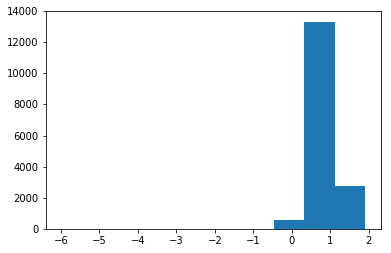

In [67]:
plt.hist(df_all['Sentiment'])

### Word complexity

In [68]:
tf = TfidfVectorizer(min_df=2, max_df=0.8, stop_words='english')
vectorizer = tf.fit(df.Text.tolist()) 

In [69]:
transformed = vectorizer.transform(df.Text.tolist())

In [70]:
transformed

<16665x67943 sparse matrix of type '<class 'numpy.float64'>'
	with 4356147 stored elements in Compressed Sparse Row format>

In [71]:
df['Word_vectors'] = df.apply(lambda row: transformed[row.name], axis=1)

In [72]:
def compute_nsb(row):
    vec = np.array(row['Word_vectors'].todense())
    K = vec.size
    return nsb_entropy.S(nsb_entropy.make_nxkx(vec, K), vec.sum(), K)

In [73]:
df['Word_entropy'] = df.apply(lambda row: compute_nsb(row), axis=1)

### Delete unnecessary fields

In [117]:
del df_all['Language']
del df_all['Notes']
del df_all['Summary']
del df_all['Title']
del df_all['URL']
del df_all['AdditionalTags']
del df_all['Characters']

### Clean up, create categorical variables

In [118]:
df_all['Chapters'] = df_all['Chapters'].fillna(0)
df_all.Words = df_all.Words/df_all.Chapters

In [119]:
df_all['Category'].fillna('Unknown', inplace=True)
df_all['Category_F_F'] = df_all['Category'].apply(lambda x: 1 if 'F/F' in x else 0)
df_all['Category_F_M'] = df_all['Category'].apply(lambda x: 1 if 'F/M' in x else 0)
df_all['Category_Gen'] = df_all['Category'].apply(lambda x: 1 if 'Gen' in x else 0)
df_all['Category_M_M'] = df_all['Category'].apply(lambda x: 1 if 'M/M' in x else 0)
df_all['Category_Multi'] = df_all['Category'].apply(lambda x: 1 if 'Multi' in x else 0)
df_all['Category_Other'] = df_all['Category'].apply(lambda x: 1 if 'Other' in x else 0)
df_all['Category_Unknown'] = df_all['Category'].apply(lambda x: 1 if 'Unknown' in x else 0)
del df_all['Category']

In [120]:
df_all['ArchiveWarnings_underage'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Underage' in x else 0)
df_all['ArchiveWarnings_death'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Major Character Death' in x else 0)
df_all['ArchiveWarnings_choose_no'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Creator Chose Not To Use Archive Warnings' in x else 0)
df_all['ArchiveWarnings_no_apply'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'No Archive Warnings Apply' in x else 0)
df_all['ArchiveWarnings_violence'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Graphic Depictions Of Violence' in x else 0)
df_all['ArchiveWarnings_noncon'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Rape/Non-Con' in x else 0)

del df_all['ArchiveWarnings']

In [121]:
# df_all = df_all[df_all['ArchiveWarnings_blood'] != 1]
# df_all = df_all[df_all['ArchiveWarnings_none'] != 1]

In [122]:
df_all['ChapterIndex'].fillna(0, inplace=True)

In [123]:
df_all['Rating_E'] = df_all['Rating'].apply(lambda x: 1 if x == 'Explicit' else 0)
df_all['Rating_G'] = df_all['Rating'].apply(lambda x: 1 if x == 'General Audiences' else 0)
df_all['Rating_M'] = df_all['Rating'].apply(lambda x: 1 if x == 'Mature' else 0)
df_all['Rating_N'] = df_all['Rating'].apply(lambda x: 1 if x == 'Not Rated' else 0)
df_all['Rating_T'] = df_all['Rating'].apply(lambda x: 1 if x == 'Teen And Up Audiences' else 0)
del df_all['Rating']

In [124]:
df_all.columns.values

array(['index', 'Author', 'Bookmarks', 'ChapterIndex', 'Chapters',
       'Comments', 'CompleteDate', 'Fandoms', 'Hits', 'Kudos',
       'PublishDate', 'Text', 'UpdateDate', 'Words', 'Dist', 'JSD',
       'Freq_relationship', 'Topic_entropy', 'Sentiment', 'Category_F_F',
       'Category_F_M', 'Category_Gen', 'Category_M_M', 'Category_Multi',
       'Category_Other', 'Category_Unknown', 'ArchiveWarnings_underage',
       'ArchiveWarnings_death', 'ArchiveWarnings_choose_no',
       'ArchiveWarnings_no_apply', 'ArchiveWarnings_violence',
       'ArchiveWarnings_noncon', 'Rating_E', 'Rating_G', 'Rating_M',
       'Rating_N', 'Rating_T'], dtype=object)

In [125]:
df_all['Fandom_harry_potter'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'harry_potter' else 0)
df_all['Fandom_dcu'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'dcu' else 0)
df_all['Fandom_doctor_who'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'doctor_who_&_related_fandoms' else 0)
df_all['Fandom_star_wars'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'star_wars_all_media_types' else 0)
df_all['Fandom_arthurian'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'arthurian_mythology_&_related_fandoms' else 0)
df_all['Fandom_supernatural'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'supernatural' else 0)
df_all['Fandom_haikyuu'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'haikyuu' else 0)
df_all['Fandom_kuroko_no_basuke'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'kuroko_no_basuke' else 0)
df_all['Fandom_hamilton_miranda'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'hamilton_miranda' else 0)
df_all['Fandom_dragon_age'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'dragon_age_all_media_types' else 0)
df_all['Fandom_the_walking_dead'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'the_walking_dead_&_related_fandoms' else 0)
df_all['Fandom_buffy'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'buffy_the_vampire_slayer' else 0)
df_all['Fandom_les_miserables'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'les_miserables_all_media_types' else 0)
df_all['Fandom_naruto'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'naruto' else 0)
df_all['Fandom_tolkien'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'tolkien_j_r_r_works_&_related_fandoms' else 0)
df_all['Fandom_shakespare'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'shakespare_william_works' else 0)
df_all['Fandom_hetalia'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'hetalia_axis_powers' else 0)
df_all['Fandom_attack_on_titan'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'attack_on_titan' else 0)
df_all['Fandom_ms_paint_adventures'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'ms_paint_adventures' else 0)
df_all['Fandom_marvel'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'marvel' else 0)
df_all['Fandom_sailor_moon'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'bishoujo_senshi_sailor_moon' else 0)
df_all['Fandom_one_direction'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'one_direction' else 0)
df_all['Fandom_sherlock'] = df_all['Fandoms'].apply(lambda x: 1 if x == 'sherlock_holmes_&_related_fandoms' else 0)

del df_all['Fandoms']

### Compute "history"

In [126]:
df_all['CompleteDate'] = df_all.apply(lambda row: date_today(row['CompleteDate']), axis = 1)
df_all['UpdateDate'] = df_all.apply(lambda row: date_today(row['UpdateDate']), axis = 1)


In [127]:
df_all['PublishDate'] = df_all.apply(lambda row: date_today(row['UpdateDate']), axis = 1)

In [128]:
def find_history(field_list):
    field_list = [10000000 if np.isnan(x) else x for x in field_list]
    return np.amin(field_list)

In [129]:
df_all['history'] = df_all.apply(lambda row: find_history([row['PublishDate'], row['CompleteDate'], row['UpdateDate']]), axis=1)

In [130]:
del df_all['PublishDate']
del df_all['CompleteDate']
del df_all['UpdateDate']

In [131]:
df_all = df_all.rename(columns = {'history':'History', 'Cos': 'Term_novelty', 'JSD': 'Topic_novelty'})

In [132]:
df_all.head(2)

,index,Author,Bookmarks,ChapterIndex,Chapters,Comments,Hits,Kudos,Text,Words,...,Fandom_tolkien,Fandom_shakespare,Fandom_hetalia,Fandom_attack_on_titan,Fandom_ms_paint_adventures,Fandom_marvel,Fandom_sailor_moon,Fandom_one_direction,Fandom_sherlock,History
1771,172709,Kila9Nishika,0.000000,1.0,2,0,7.000000,1.500000,This is an emergency.\xc2\xa0 Repeat.\xc2\xa0 ...,2277.000000,...,0,0,0,0,0,0,0,0,0,3298.0
2453,181007,sylvanawood,0.272727,30.0,99,0,29.767677,1.262626,\nHogwarts School of Witchcraft and WizardrySt...,345.939394,...,0,0,0,0,0,0,0,0,0,3086.0


In [133]:
df_all.to_csv(top_tail_option + '_' + novelty_field + '_novelty_regression.tsv', sep = '\t', index=False)